# Implementaion Graph Convolutional Network
## task: node embedding
### some parts are implementing easily because of simplicity, Please check comments

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create data
data_size = 100
data1 = np.random.normal(-1, 1, (2,data_size))
data2 = np.random.normal(1, 1, (2, data_size))

In [3]:
def create_adj(data):
    A = np.zeros((data.shape[1],data.shape[1]))
    for i in range(data.shape[1]):
        dist = np.empty(data.shape[1])
        for j in range(data.shape[1]):
            cost = 0
            if i == j:
                cost = 10000
            dist[ j ] = np.sqrt(np.sum((data[:, i]-data[:, j])**2)) + cost
        c = np.argsort(dist)
        A[i,c[:5]] = 1
    
    return A

In [4]:
#show data
def plot_with_line(data1,data2,adj):
    plt.scatter(data1[0,:],data1[1,:],color="blue")
    plt.scatter(data2[0,:],data2[1,:],color="red")
    for i in range(adj.shape[0]):
        if i >= data_size:
            x1 = data2[:,i-data_size]
        else:
            x1 = data1[:,i]
        for j in range(adj.shape[0]):
            if (adj[i,j]):
                if j >= data_size:
                    x2 = data2[:,j-data_size]
                else:
                    x2 = data1[:,j]
                plt.plot([x1[0],x2[0]],[x1[1],x2[1]],color="gray",alpha=0.8)
    
    plt.show()

In [5]:
#Graph Convolution Class
class GraphConvolution(nn.Module):
    def __init__(self, i_feature, o_feature):
        super(GraphConvolution,self).__init__()
        """args:
        i_feature: feature size of input
        o_feature: feature size of output
        """
        self.weight = nn.parameter.Parameter(torch.FloatTensor(i_feature,o_feature))
        self.bias = nn.parameter.Parameter(torch.FloatTensor(o_feature))
        self.weight_init()
        
    def weight_init(self):
        stdv = 1. / np.sqrt(self.weight.shape[1])
        self.weight.data.uniform_(-stdv,stdv)
        self.bias.data.uniform_(-stdv,stdv)
        
    def forward(self, X, Ahat):
        """args:
        X: features of each node (N,F)
            N: the number of node
            F: Feature of each node
        Ahat: Adjacent matrix (N,N)
        """
        hidden = torch.mm(X, self.weight)
        outputs = torch.mm(Ahat,hidden) #in real application, Ahat is sparse
        
        return outputs + self.bias

In [6]:
#Graph Convolutional Network
class GCN(nn.Module):
    def __init__(self,hidden_size=16):
        super(GCN,self).__init__()
        self.gc1 = GraphConvolution(2, hidden_size)
        self.gc2 = GraphConvolution(hidden_size, 2) #2 means the embed points of node (x, y)    
    def forward(self, x, adj):
        h = self.gc1(x,adj)
        h = F.relu(h)
        o = self.gc2(h,adj)
        return torch.tanh(o) #embed in [-1, 1]

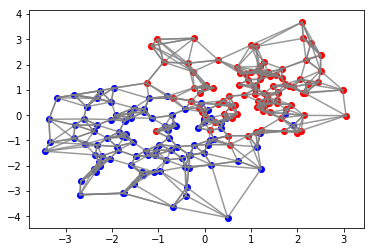

In [7]:
#data preprocess
#First, creating adjacent matrix
data = np.concatenate((data1,data2),axis=1)

#calculate distance , in this case, adjacent matrix
A = create_adj(data)
#show
plot_with_line(data1,data2,A)

In [8]:
#consider self-loop to calculate
Ahat = A + np.eye(A.shape[0])

#calculate constant value for normalization
# because each node has different edge, so to restrict gradient explosion, we need to normalize each node by the degree of edge
D = np.sum(1. * (Ahat > 0),axis=0) #In real application, adjacent matrix has value 0 or 1 
D.reshape(-1,1)

#So, Final Adjacent matrix is below
Ahat = Ahat / D
#But this is very simple normalization method

In [9]:
#Next Set Each Node Feature
X = data.transpose(1,0)#here, we set points as feature(In real case, the feature might be embeddings)

In [10]:
#set teacher label
class1 = torch.FloatTensor([-1., -1.])
class2 = torch.FloatTensor([1.,1.])
#Above mean class1(in case of this implementation, data1 should be embedded in (-1, -1)
#class2(in case of this implementation, data2 should be embedded in (1, 1)

In [11]:
#set model
model = GCN()
#set optimizer
optimizer = optim.SGD(model.parameters(),lr=0.1)
#set loss
criterion = nn.MSELoss()
#set epoch
n_epoch = 10
X = torch.FloatTensor(X)
Ahat = torch.FloatTensor(Ahat)

In [12]:
def visualize(epoch,data1,data2,adj):
    plt.title("epoch " + str(epoch))
    outputs = model(X,Ahat)
    outputs = outputs.detach().numpy()
    for i,o in enumerate(outputs):
        if i < data_size:
            plt.scatter(o[0],o[1],color="blue")
        else:
            plt.scatter(o[0],o[1],color="red")

    plt.show()

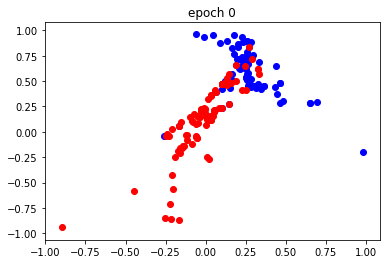

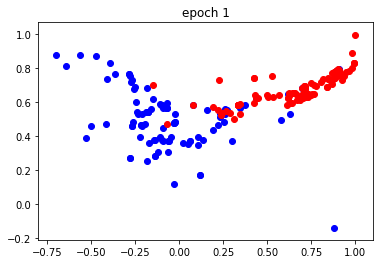

epoch:[1],   loss:[3.0850894451141357]


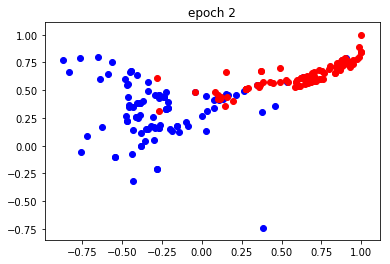

epoch:[2],   loss:[1.2698934078216553]


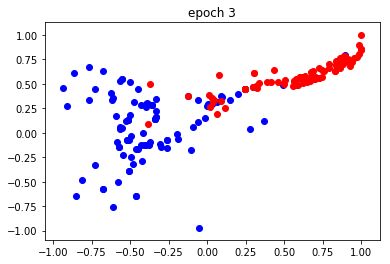

epoch:[3],   loss:[0.7865077257156372]


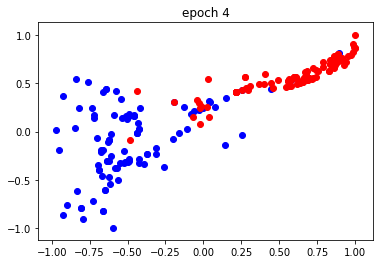

epoch:[4],   loss:[0.40118956565856934]


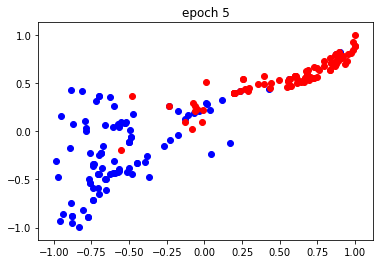

epoch:[5],   loss:[0.20970389246940613]


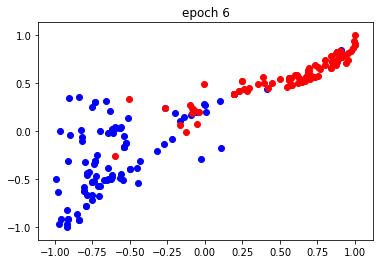

epoch:[6],   loss:[0.1302625834941864]


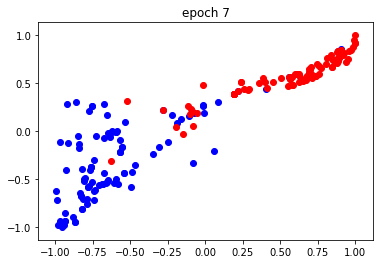

epoch:[7],   loss:[0.09237213432788849]


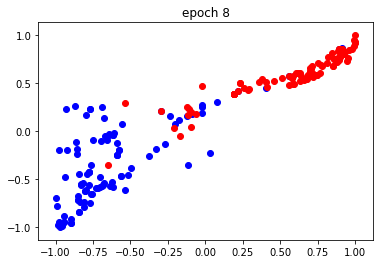

epoch:[8],   loss:[0.07083006203174591]


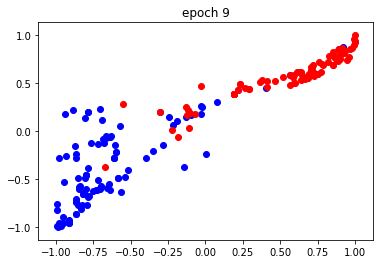

epoch:[9],   loss:[0.057054303586483]


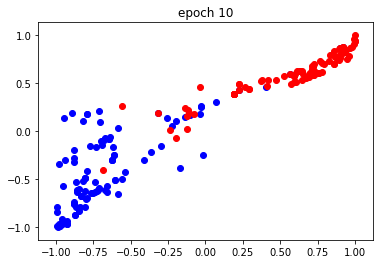

epoch:[10],   loss:[0.04754358157515526]


In [13]:
#training
visualize(0,data1,data2,A)
for epoch in range(n_epoch):
    optimizer.zero_grad()
    outputs = model(X, Ahat)
    
    #We consider, semi-supervised learning, so we set data[0] is class 1, data[-1] is class2
    #Left node does not have label
    cls1_loss = criterion(outputs[0].unsqueeze(0),class1.unsqueeze(0))
    cls2_loss = criterion(outputs[-1].unsqueeze(0),class2.unsqueeze(0))
    
    loss = cls1_loss+cls2_loss
    loss.backward()
    optimizer.step()
    visualize(epoch+1,data1,data2,A)
    
    print("epoch:[{}],   loss:[{}]".format(epoch+1,loss.item()))

# Above results mean data1(blue dot) are embed near (-1,1) and data2(red dot) are embed (1,1)